In [1]:
import os
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import time
import math
import matplotlib.pyplot as plt

In [2]:
# Read data
df = pd.read_csv('.\eth_2018_price_10T.csv',index_col=0)
df.head()

,mean_price,min_price,max_price
2017-12-31 19:00:00,739.337923,732.264535,746.00
2017-12-31 19:10:00,737.486161,729.949027,745.32
2017-12-31 19:20:00,736.453282,727.042308,744.16
2017-12-31 19:30:00,735.683226,728.656970,742.94
2017-12-31 19:40:00,734.582817,728.689437,739.08


In [3]:
# There are some rows that will cause error
error_value = np.unique(np.where(np.isfinite(df)==0)[0]).tolist()
error_value

[9978, 9979, 9980, 9981, 9982, 9983]

In [4]:
# Drop the error rows
df.drop(df.iloc[error_value].index, axis = 0, inplace = True)

# initialize params

In [5]:
N = 18 # batch size used to build model
M = 600 # timespan we use to train the model
score_threshold = 0.7 # rsrs threshold
# Parameters used to calculate moving average
mean_day = 20 # timespan to calculate the most recent close price
mean_diff_day = 3 # time difference to calculate the before close price


In [6]:
df.iloc[:M+N]

,mean_price,min_price,max_price
2017-12-31 19:00:00,739.337923,732.264535,746.000000
2017-12-31 19:10:00,737.486161,729.949027,745.320000
2017-12-31 19:20:00,736.453282,727.042308,744.160000
2017-12-31 19:30:00,735.683226,728.656970,742.940000
2017-12-31 19:40:00,734.582817,728.689437,739.080000
...,...,...,...
2018-01-05 01:10:00,995.418574,980.490000,1004.043402
2018-01-05 01:20:00,999.516768,986.606473,1013.863225
2018-01-05 01:30:00,1002.937961,991.929847,1016.107908
2018-01-05 01:40:00,1003.522279,991.720005,1020.239278


In [7]:
# main algorithm
def get_ols(x, y):
    slope, intercept = np.polyfit(x, y, 1)
    r2 = 1 - (sum((y - (slope * x + intercept))**2) / ((len(y) - 1) * np.var(y, ddof=1)))
    return (intercept, slope, r2)

In [8]:
# Base slope
def initial_slope_series(start_time):
    start_time = np.where(df.index==start_time)[0][0]
    data = df.iloc[start_time-(N + M):start_time]
    return [get_ols(data.min_price[i:i+N], data.max_price[i:i+N])[1] for i in range(M)]

In [9]:
# Calculate std rsrs score
def get_zscore(slope_series):
    mean = np.mean(slope_series)
    std = np.std(slope_series)
    return (slope_series[-1] - mean) / std

In [10]:
# pick a day to start
start_time = '2018-01-05 02:00:00'

In [11]:
# leave the last one out to avoid duplication
# this is our base slop series
slope_series = initial_slope_series(start_time)[:-1]  # we append the slope of start_time in function: get_timing_signal
len(slope_series)

599

In [12]:
get_zscore(slope_series)

0.8133157629700516

In [13]:
def get_timing_signal(start_time):
    start_time = np.where(df.index==start_time)[0][0]
    # calculate MA signal
    close_data = df.iloc[start_time-(mean_day + mean_diff_day):start_time]
    # 23 days，take the last 20 days
    today_MA = close_data.mean_price[mean_diff_day:].mean() 
    # 23 days，take the first 20 days
    before_MA = close_data.mean_price[:-mean_diff_day].mean()
    # calculate rsrs signal
    high_low_data = pd.DataFrame({'low':df.iloc[start_time-N:start_time].min_price.to_list(),
                                  'high':df.iloc[start_time-N:start_time].max_price.to_list()})
    intercept, slope, r2 = get_ols(high_low_data.low, high_low_data.high)
    slope_series.append(slope)

    rsrs_score = get_zscore(slope_series[-M:]) * r2
    # use signal combo to get final signal
    if rsrs_score > score_threshold and today_MA > before_MA:
        return "BUY"
    elif rsrs_score < -score_threshold and today_MA < before_MA:
        return "SELL"
    else:
        return "NEUTRAL"

In [14]:
# test
get_timing_signal(start_time)  #'2018-01-05 02:00:00'

'BUY'

# Run the model

In [15]:
# start_time is the time str when the model starts, we turn it into the location where the time is located in the df
def to_iloc(start_time):
    return np.where(df.index==start_time)[0][0]

In [16]:
signal = np.array(df.iloc[to_iloc(start_time):,:].index.map(lambda index:get_timing_signal(index)))
signal

array(['BUY', 'BUY', 'BUY', ..., 'NEUTRAL', 'NEUTRAL', 'NEUTRAL'],
      dtype=object)

In [17]:
df = df.join(pd.DataFrame(signal, index=df.iloc[to_iloc(start_time):,:].index,columns = ["signal"]))
df.tail()

,mean_price,min_price,max_price,signal
2018-12-31 18:10:00,132.042912,129.977798,136.44,NEUTRAL
2018-12-31 18:20:00,131.611979,130.681024,136.35,NEUTRAL
2018-12-31 18:30:00,131.703035,130.436754,136.35,NEUTRAL
2018-12-31 18:40:00,131.807298,130.050000,136.40,NEUTRAL
2018-12-31 18:50:00,131.368238,129.875253,136.00,NEUTRAL


In [18]:
# View the signals starting from our chosen start_time
df.iloc[to_iloc(start_time):,:]

,mean_price,min_price,max_price,signal
2018-01-05 02:00:00,1010.126541,994.220278,1017.354890,BUY
2018-01-05 02:10:00,1007.836374,991.535325,1016.554638,BUY
2018-01-05 02:20:00,1003.163752,965.000000,1011.876101,BUY
2018-01-05 02:30:00,1001.615969,957.800000,1009.417692,NEUTRAL
2018-01-05 02:40:00,999.320913,985.784573,1006.663222,NEUTRAL
...,...,...,...,...
2018-12-31 18:10:00,132.042912,129.977798,136.440000,NEUTRAL
2018-12-31 18:20:00,131.611979,130.681024,136.350000,NEUTRAL
2018-12-31 18:30:00,131.703035,130.436754,136.350000,NEUTRAL
2018-12-31 18:40:00,131.807298,130.050000,136.400000,NEUTRAL


In [19]:
df.signal.value_counts()

NEUTRAL    44313
BUY         6119
SELL        1504
Name: signal, dtype: int64

In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 52554 entries, 2017-12-31 19:00:00 to 2018-12-31 18:50:00
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   mean_price  52554 non-null  float64
 1   min_price   52554 non-null  float64
 2   max_price   52554 non-null  float64
 3   signal      51936 non-null  object 
dtypes: float64(3), object(1)
memory usage: 4.5+ MB


In [22]:
%matplotlib inline

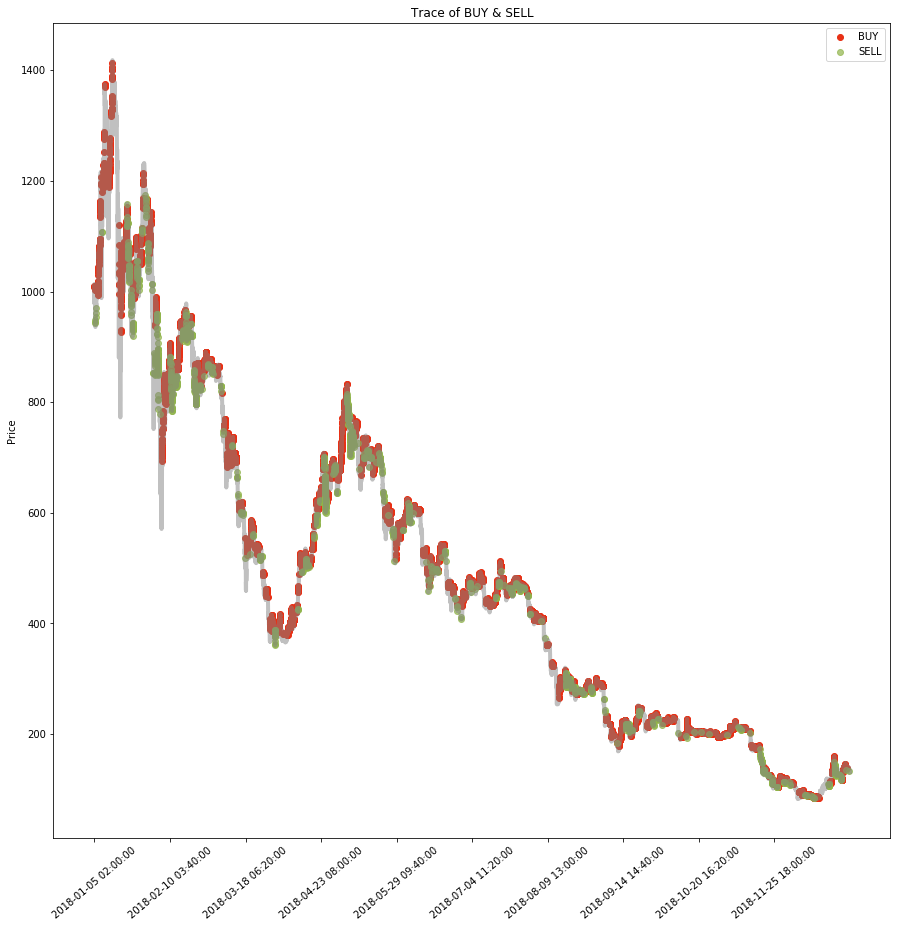

In [74]:
total_time = df.iloc[to_iloc(start_time):,:].index.tolist()
fig, ax = plt.subplots()

plt.rcParams["figure.figsize"] = (15,15)
ax.plot(total_time, df.iloc[to_iloc(start_time):,0], linewidth=4, alpha = 0.5, color='#828282')
ax.scatter(df.iloc[np.where(df['signal']=='BUY')[0],0].index.tolist(),df.iloc[np.where(df['signal']=='BUY')[0],0], label = 'BUY', color='#e83015')
ax.scatter(df.iloc[np.where(df['signal']=='SELL')[0],0].index.tolist(),df.iloc[np.where(df['signal']=='SELL')[0],0], label = 'SELL', alpha = 0.7, color='#90b44b')

plt.legend()
xticks=list(range(0,len(total_time),round(len(total_time)/10)))
xlabels=[total_time[x] for x in xticks]
ax.set_xticks(xticks)
ax.set_xticklabels(xlabels, rotation=40)
ax.set_ylabel('Price')
ax.set_title('Trace of BUY & SELL')
plt.show()